# GloVE

Let's work on implementation of GloVE.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Download nltk corpus

In [121]:
import nltk
from nltk.corpus import reuters

In [122]:
# nltk.download('reuters')
# nltk.download('punkt')

In [123]:
# print(len(nltk.corpus.reuters.sents()))

In [124]:
corpus = nltk.corpus.reuters.sents()

In [125]:
corpus = corpus[:1000]
# corpus

In [126]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))

In [127]:
#vocab size
voc_size = len(vocab)
print(voc_size)

4972


In [128]:
#append UNK
vocab.append('<UNK>')

In [129]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}

In [130]:
import pickle
pickle.dump(vocab, open('./vocab/glove_vocab.pkl', 'wb'))

In [49]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()}

## 2. Build Co-occurence Matrix X

Here, we need to count the co-occurence of two words given some window size.  We gonna use window size of 1.

In [50]:
from collections import Counter

X_i = Counter(flatten(corpus)) # X_i
# X_i

In [51]:
# Make skip gram of one size window
skip_grams = []
# loop each word sequence
# we starts from 1 because 0 has no context
# we stop at second last for the same reason
for sent in corpus:
    for i in range(2, len(sent) - 2):
        target = sent[i]
        context = [sent[i - 2], sent[i - 1], sent[i + 1], sent[i + 2]]
        for w in context:
            skip_grams.append((target, w))

In [52]:
X_ik_skipgram = Counter(skip_grams) # Co-occurece in window size 1

### Weighting function

GloVe includes a weighting function to scale down too frequent words.

<img src = "figures/glove_weighting_func.png" width=400>

In [53]:
#simply a normalized function...don't worry too much
def weighting(w_i, w_j, X_ik):

    #check whether the co-occurrences exist between these two words
    try:
        x_ij = X_ik[(w_i, w_j)]
    except:
        x_ij = 1  #if does not exist, set it to 1

    x_max = 100 #100 # fixed in paper  #cannot exceed 100 counts
    alpha = 0.75

    #if co-occurrence does not exceed 100, scale it based on some alpha
    if x_ij < x_max:
        result = (x_ij/x_max)**alpha  #scale it
    else:
        result = 1  #if is greater than max, set it to 1 maximum

    return result

In [54]:
from itertools import combinations_with_replacement

X_ik = {}  #for keeping the co-occurences
weighting_dic = {} #scaling the percentage of sampling

for bigram in combinations_with_replacement(vocab, 2):
    if X_ik_skipgram.get(bigram) is not None:  #matches
        co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
        X_ik[bigram] = co_occer + 1 # + 1 for stability issue
        X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
    else:
        pass

    weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
    weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

# print(f"{X_ik=}")
# print(f"{weighting_dic=}")


## 3. Prepare train data

In [55]:
# for c in corpus:
#     print(c)

In [56]:
import math

def random_batch(batch_size, word_sequence, skip_grams, X_ik, weighting_dic):

    #convert to id since our skip_grams is word, not yet id
    skip_grams_id = [(word2index[skip_gram[0]], word2index[skip_gram[1]]) for skip_gram in skip_grams]

    random_inputs = []
    random_labels = []
    random_coocs  = []
    random_weightings = []
    random_index = np.random.choice(range(len(skip_grams_id)), batch_size, replace=False) #randomly pick without replacement

    for i in random_index:
        random_inputs.append([skip_grams_id[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams_id[i][1]])  # context word, e.g., 3

        #get cooc
        pair = skip_grams[i]
        try:
            cooc = X_ik[pair]
        except:
            cooc = 1
        random_coocs.append([math.log(cooc)])

        #get weighting
        weighting = weighting_dic[pair]
        random_weightings.append([weighting])

    return np.array(random_inputs), np.array(random_labels), np.array(random_coocs), np.array(random_weightings)

### Testing the method

In [57]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)

print("Input: ", input_batch)
print("Target: ", target_batch)
print("Cooc: ", cooc_batch)
print("Weighting: ", weighting_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[3520]
 [4135]]
Target:  [[1189]
 [1189]]
Cooc:  [[1.38629436]
 [3.17805383]]
Weighting:  [[0.08944272]
 [0.34289285]]


## 4. Model

<img src ="figures/glove.png">

In [2]:
class GloVe(nn.Module):

    def __init__(self, vocab_size,embed_size):
        super(GloVe,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, embed_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, embed_size) # out embedding

        self.v_bias = nn.Embedding(vocab_size, 1)
        self.u_bias = nn.Embedding(vocab_size, 1)

    def forward(self, center_words, target_words, coocs, weighting):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]

        center_bias = self.v_bias(center_words).squeeze(1)
        target_bias = self.u_bias(target_words).squeeze(1)

        inner_product = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        #note that coocs already got log
        loss = weighting*torch.pow(inner_product +center_bias + target_bias - coocs, 2)

        return torch.sum(loss)

## 5. Training

In [59]:
batch_size     = 10 # mini-batch size
embedding_size = 2 #so we can later plot
model          = GloVe(voc_size, embedding_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [60]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [61]:
import time

# Training
num_epochs = 1000
for epoch in range(num_epochs):

    start = time.time()

    input_batch, target_batch, cooc_batch, weighting_batch = random_batch(batch_size, corpus, skip_grams, X_ik, weighting_dic)
    input_batch  = torch.LongTensor(input_batch)         #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch)        #[batch_size, 1]
    cooc_batch   = torch.FloatTensor(cooc_batch)         #[batch_size, 1]
    weighting_batch = torch.FloatTensor(weighting_batch) #[batch_size, 1]

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, cooc_batch, weighting_batch)

    loss.backward()
    optimizer.step()

    end = time.time()

    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 100 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 100 | cost: 28.051149 | time: 0m 0s
Epoch: 200 | cost: 9.686008 | time: 0m 0s
Epoch: 300 | cost: 14.526970 | time: 0m 0s
Epoch: 400 | cost: 15.254799 | time: 0m 0s
Epoch: 500 | cost: 19.835958 | time: 0m 0s
Epoch: 600 | cost: 35.506367 | time: 0m 0s
Epoch: 700 | cost: 6.913466 | time: 0m 0s
Epoch: 800 | cost: 39.837910 | time: 0m 0s
Epoch: 900 | cost: 29.825298 | time: 0m 0s
Epoch: 1000 | cost: 19.204004 | time: 0m 0s


In [62]:
# X_ik = {}  #for keeping the co-occurences
# weighting_dic = {} #scaling the percentage of sampling

# for bigram in skip_grams:
#     if X_ik_skipgram.get(bigram) is not None:  #matches
#         co_occer = X_ik_skipgram[bigram]  #get the count from what we already counted
#         X_ik[bigram] = co_occer + 1 # + 1 for stability issue
#         X_ik[(bigram[1],bigram[0])] = co_occer+1   #count also for the opposite
#     else:
#         pass

#     weighting_dic[bigram] = weighting(bigram[0], bigram[1], X_ik)
#     weighting_dic[(bigram[1], bigram[0])] = weighting(bigram[1], bigram[0], X_ik)

# print(f"{X_ik=}")
# print(f"{weighting_dic=}")

## 6. Plotting the embeddings

In [63]:
#list of vocabs
vocab[:10]

['barred',
 'weight',
 'transport',
 'Gerard',
 'blunt',
 'octane',
 'domestically',
 'year',
 'fixed',
 'preparing']

In [64]:
word = vocab[0]

In [65]:
#numericalization
id = word2index[word]
id

0

In [66]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [67]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[ 0.0027, -0.8143]], grad_fn=<EmbeddingBackward0>),
 tensor([[-0.7881,  0.4899]], grad_fn=<EmbeddingBackward0>))

In [68]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-0.1622, grad_fn=<SelectBackward0>)

In [69]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

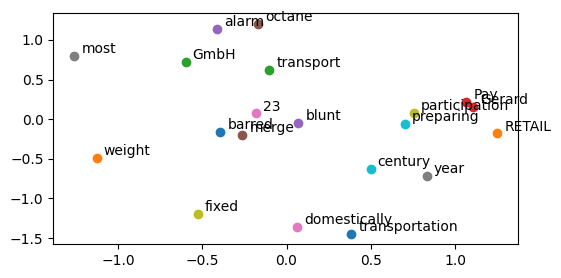

In [70]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

## 7. Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [71]:
# vocab

In [72]:
# #let's try similarity between first and second, and second and third
# cat          = get_embed('cat')
# fruit        = get_embed('fruit')
# animal       = get_embed('animal')

In [73]:
# #numpy version
# from numpy import dot
# from numpy.linalg import norm

# def cos_sim(a, b):
#     cos_sim = dot(a, b)/(norm(a)*norm(b))
#     return cos_sim

# print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
# print(f"cat vs. animal: ",       cos_sim(cat, animal))
# print(f"cat vs. cat: ",          cos_sim(cat, cat))

In [74]:
# #scipy version
# from scipy import spatial

# def cos_sim(a, b):
#     cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
#     return cos_sim

# print(f"cat vs. fruit: ",     cos_sim(cat, fruit))
# print(f"cat vs. animal: ",       cos_sim(cat, animal))
# print(f"cat vs. cat: ",          cos_sim(cat, cat))

## 8. Save Model

In [75]:
torch.save(model, './model/GloVe.pth')

## 9. Testing

In [100]:
import torch
import numpy as np
from scipy import spatial
from sklearn.neighbors import KDTree

class AnalogyTest():
    def __init__(self, model, testfile_path, vocab):
        self.testfile_path = testfile_path
        self.model = model
        self.vocab = vocab
        self.embeddings = [self.get_embed(word) for word in self.vocab[:-1]]
        self.kdtree = KDTree(self.embeddings)

    def sections(self):
        section_list = []
        with open(self.testfile_path, 'r') as file:
            for line in file:
                # find capital-common-countries section
                if line.startswith(':'):
                    section = line[1:].strip()
                    section_list.append(section)
        return section_list

    def get_embed(self, word):
        if word in self.vocab[:-1]:
            id_tensor = torch.LongTensor([word2index[word]])
            v_embed = self.model.embedding_v(id_tensor)
            u_embed = self.model.embedding_u(id_tensor)
            word_embed = (v_embed + u_embed) / 2
            x, y = word_embed[0][0].item(), word_embed[0][1].item()
            return np.array([x, y])
        else:
            return None
    
    def cos_sim(self, w1, w2):
        w1 = self.get_embed(w1)
        w2 = self.get_embed(w2)
        cos_sim = 1 - spatial.distance.cosine(w1, w2)  #distance = 1 - similarlity, because scipy only gives distance
        return cos_sim

    def test(self, section):
        total_count = 0
        correct_count = 0
        score = 0
        i = 0
        current_section = None

        with open(self.testfile_path, 'r') as file:

            ##################
            print('Sample Inferences')
            print('='*20)    

            for line in file:
                
                # max_similarity = -1

                if line.startswith(':'):
                    current_section = line[1:].strip()
                    continue

                if current_section == section:
                    analogy = line.strip().split()
                    if len(analogy) != 4:
                        continue
                    w1, w2, w3, w4 = analogy

                    try:
                        vec_w1 = self.get_embed(w1)
                        vec_w2 = self.get_embed(w2)
                        vec_w3 = self.get_embed(w3)
                        vec_w4 = self.get_embed(w4)

                        if any(vec is None for vec in [vec_w1, vec_w2, vec_w3, vec_w4]):
                            # print('none')
                            continue 

                        vec_w4_inferred = vec_w2 + vec_w3 - vec_w1

                        # for word in self.vocab:
                            
                        #     word_vec = self.get_embed(word)
                        #     similarity = 1 - spatial.distance.cosine(word_vec, vec_w4)

                        #     if similarity > max_similarity:
                        #         max_similarity = similarity
                        #         infer = word
                        _, indices = self.kdtree.query([vec_w4_inferred], k=1)
                        infer = self.vocab[indices[0][0]]
                        
                        total_count += 1
                        if infer == w4:
                            correct_count += 1
                        similarity = max(-1, 1 - spatial.distance.cosine(self.get_embed(infer), vec_w4))
                        score += similarity

                        ################
                        while i < 3:
                            print(w1, w2, w3, w4)
                            print(vec_w1, vec_w2, vec_w3)
                            try:
                                print(f"Correct word's vector: {self.get_embed(w4)}")
                            except:
                                print(f'{w4} is not in the trained vocab')
                            print(f"Inferred vector: {self.get_embed(infer)}")
                            print(f'Inferred word: {infer}')
                            print(f'Similarity: {similarity}\n')
                            i += 1
                            break
                    except KeyError as e:
                        # print(f'"{e}" is not found in the trained vocabulary.')
                        pass     

        if total_count == 0:
            print('No test is performed')
            return 0
        accuracy = correct_count / total_count
        print('='*20)  
        print(f'Total test: {total_count}\nCorrect words: {correct_count}\nAccuracy: {accuracy}\nScore: {score}')
        return accuracy

In [77]:
testfile_path = './testing/word-test.v1.txt'
model = torch.load('./model/GloVe.pth')

In [78]:
# vocab

In [101]:
analogy_test = AnalogyTest(model, testfile_path, vocab)

In [102]:
# analogy_test.sections()

In [103]:
import warnings
warnings.filterwarnings('ignore')

In [104]:
accuracy = analogy_test.test(section = 'capital-common-countries')

Sample Inferences
Canberra Australia London England
[-0.6065194  -1.74740052] [-0.64113224 -0.37048629] [-1.26576054  0.94679606]
Correct word's vector: [-0.55583042  0.76225638]
Inferred vector: [-0.93714243  2.20125914]
Inferred word: offers
Similarity: 0.9742195844175561

Canberra Australia Oslo Norway
[-0.6065194  -1.74740052] [-0.64113224 -0.37048629] [0.40594709 0.30819339]
Correct word's vector: [-0.59127223 -0.43502334]
Inferred vector: [0.36179698 1.56954479]
Inferred word: fees
Similarity: -0.7584074719921556

Canberra Australia Paris France
[-0.6065194  -1.74740052] [-0.64113224 -0.37048629] [ 0.24804589 -0.62438774]
Correct word's vector: [-0.50202203  0.24556623]
Inferred vector: [0.22988027 0.77504712]
Inferred word: vice
Similarity: 0.16582773694966502

Total test: 20
Correct words: 0
Accuracy: 0.0
Score: 5.570705108806251


In [105]:
accuracy = analogy_test.test(section = 'gram7-past-tense')

Sample Inferences
describing described falling fell
[-0.64547324 -0.6083023 ] [ 1.0609864  -0.05454478] [0.0191555  0.09183234]
Correct word's vector: [-0.67611384  1.42710841]
Inferred vector: [1.67360914 0.68146759]
Inferred word: feared
Similarity: -0.055726752092499554

describing described increasing increased
[-0.64547324 -0.6083023 ] [ 1.0609864  -0.05454478] [ 0.10195164 -0.56648493]
Correct word's vector: [ 0.30036402 -0.32026541]
Inferred vector: [ 1.72800684 -0.10236938]
Inferred word: Medical
Similarity: 0.7260188513525497

describing described looking looked
[-0.64547324 -0.6083023 ] [ 1.0609864  -0.05454478] [-1.12409914  1.24928677]
Correct word's vector: [-0.09264372 -1.75108278]
Inferred vector: [0.55274796 1.72373736]
Inferred word: directors
Similarity: -0.9670419278362112

Total test: 72
Correct words: 0
Accuracy: 0.0
Score: -12.09324790453079


## 10. Similarity testing

In [3]:
model = torch.load('./model/GloVe.pth')

In [4]:
import pickle

vocab = pickle.load(open('./vocab/glove_vocab.pkl', 'rb'))

In [5]:
word2index = {w: i for i, w in enumerate(vocab)}

In [6]:
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

In [7]:
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

In [8]:
from scipy.stats import spearmanr

test_performed = 0
se = 0

sim_list = []
inferred_sim_list = []

for line in open('./testing/wordsim_similarity_goldstandard.txt', 'rb'):
    if len(line.split()) != 3:
        continue
    test = line.decode('utf-8').split()
    w1, w2, sim = test
    if w1 not in vocab or w2 not in vocab:
        continue
    # transformed the scalar range from [-1, 1] to [0,10] linearly to match the range of similarity in testing file
    inferred_sim = cos_sim(get_embed(w1), get_embed(w2)) * 5 + 5 
    test_performed += 1
    se += (inferred_sim - float(sim)) ** 2
    sim_list.append(sim)
    inferred_sim_list.append(inferred_sim)

if test_performed != 0:
    mse = se / test_performed
    print(f'{test_performed} tests were performed')
    print(f'MSE: {mse}')
else:
    print('no test is performed')

print(spearmanr(sim_list, inferred_sim_list))

35 tests were performed
MSE: 20.37536700502739
SignificanceResult(statistic=0.012047349148786954, pvalue=0.9452387522390693)
